Training Rule1 score is: 0.422
Training Rule2 score is: 0.422
Training Rule3 score is: 0.451
Training Rule4 score is: 0.423
Training Rule5 score is: 0.401
Training Rule6 score is: 0.447
Training Rule7 score is: 0.453
Training Rule8 score is: 0.370
Training Rule9 score is: 0.452
Training Rule10 score is: 0.460
Training Rule11 score is: 0.363
Training Rule12 score is: 0.457
Training Rule13 score is: 0.363
Training Rule14 score is: 0.239
Training Rule15 score is: 0.173
Training Rule16 score is: 0.117
Starting genetic algorithm optimization with 100 generations
Population size: 10, Parents: 6, Features: 16
Progress: 0%...

/var/folders/rs/2gfhs5rx3y98jjkwk65m3byc0000gn/T/ipykernel_80784/435171793.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  offspring_crossover[idx, gene_idx] = offspring_crossover[idx, gene_idx] + random_value


10%...20%...30%...40%...50%...60%...70%...80%...90%...100% Complete!
Best fitness value: 0.0003


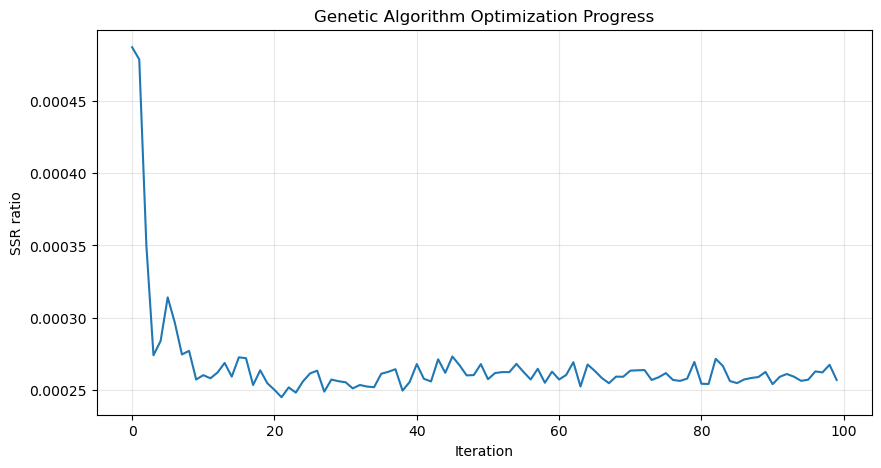

Training data evaluation:
The maximum position is 1.000, the mean position is 0.432.
The return over the period is: 22.69%
Maximum drawdown is: -0.890%
SR ratio is: 9.038
Testing data evaluation:
The maximum position is 0.884, the mean position is 0.467.
The return over the period is: 12.77%
Maximum drawdown is: -0.123%
SR ratio is: 5.815


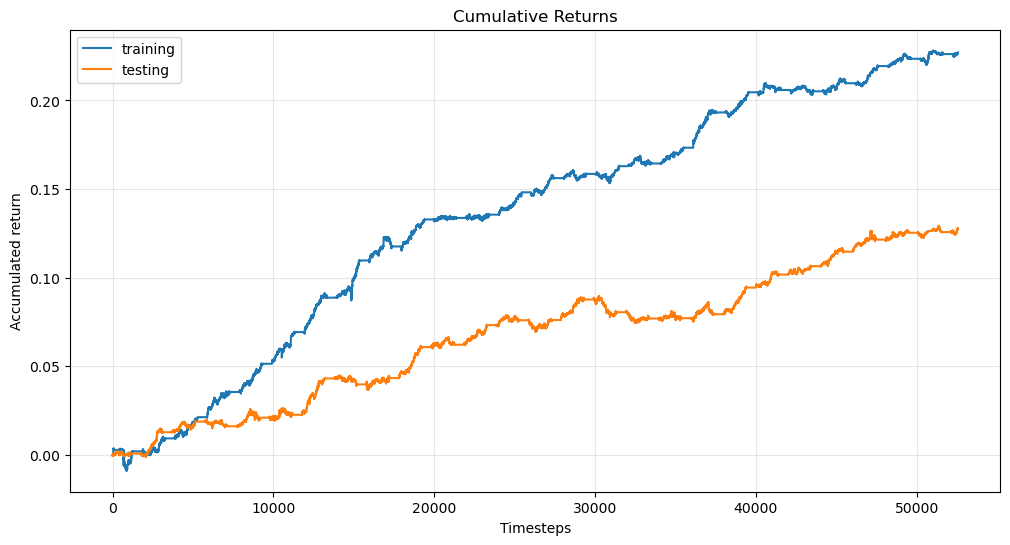

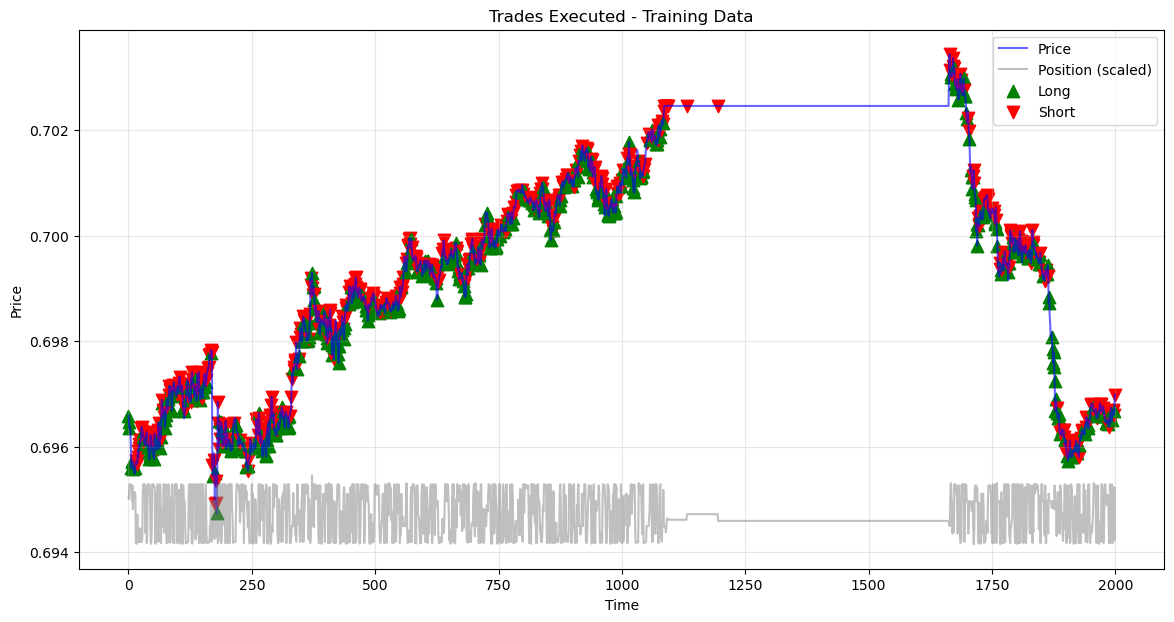

Total number of trades: 1181


IndexError: positional indexers are out-of-bounds

In [6]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tradingrule import *

# %% [markdown]
# ### Genetic Algorithm Implementation (Fixed Version)
# 
# We're redefining the necessary GA functions here to avoid import issues

# %%
# Define all necessary GA functions directly in this notebook
def cal_pop_fitness(equation_inputs, pop, opt=0):
    """
    Calculating the fitness value of each solution in the current population.
    Opt = 0 is the GAMSSR model
    """
    logr = equation_inputs[:, 0]  # n,
    positions = pop @ equation_inputs[:, 1:].T
    port_r = (positions * logr).astype(np.float64)
    
    # Handle potential issues with negative returns to prevent division by zero
    neg_sum = np.sum(port_r[port_r < 0])
    if neg_sum >= 0:  # No negative returns or sum is zero
        neg_sum = -0.0001  # Small negative number to avoid division by zero
        
    SSR = np.mean(port_r, axis=1) / np.std(port_r, axis=1) / (-neg_sum)
    return SSR

def select_mating_pool(pop, fitness, num_parents):
    """
    Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    """
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

def crossover(parents, offspring_size):
    """
    Performs crossover between parents to create offspring
    """
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k % parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1) % parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, num_mutations=1):
    """
    Performs mutation on offspring
    """
    mutations_counter = np.uint8(offspring_crossover.shape[1] / num_mutations)
    # Mutation changes a number of genes as defined by the num_mutations argument. The changes are random.
    for idx in range(offspring_crossover.shape[0]):
        gene_idx = mutations_counter - 1
        for _ in range(num_mutations):
            # The random value to be added to the gene.
            random_value = np.random.uniform(-1.0, 1.0, 1)
            offspring_crossover[idx, gene_idx] = offspring_crossover[idx, gene_idx] + random_value
            gene_idx = gene_idx + mutations_counter
    return offspring_crossover

def GA_train(training_df, optimizing_selection=0, sol_per_pop=8, num_parents_mating=4, num_generations=200, show_progress=True):
    """
    Genetic algorithm training function with fixed references to GA functions
    
    Parameters:
    training_df - DataFrame with training data
    optimizing_selection - Optimization criteria (0 by default)
    sol_per_pop - Population size (8 by default)
    num_parents_mating - Number of parents for mating (4 by default)
    num_generations - Number of generations to evolve (200 by default)
    show_progress - Whether to display progress updates (True by default)
    """
    # Inputs of the equation.
    equation_inputs = training_df.values
    # Number of the weights we are looking to optimize.
    num_weights = training_df.shape[1]-1

    # Defining the population size.
    pop_size = (sol_per_pop, num_weights) 
    # The population will have sol_per_pop chromosome 
    # where each chromosome has num_weights genes.
    
    # Creating the initial population.
    new_population = np.random.uniform(low=-1.0, high=1.0, size=pop_size)

    best_outputs = []
    
    # Simple progress tracking
    if show_progress:
        print(f"Starting genetic algorithm optimization with {num_generations} generations")
        print(f"Population size: {sol_per_pop}, Parents: {num_parents_mating}, Features: {num_weights}")
        print("Progress: ", end="", flush=True)
        milestone = max(1, num_generations // 10)  # Report progress every 10%
    
    for generation in range(num_generations):
        # Show progress
        if show_progress and generation % milestone == 0:
            print(f"{generation//milestone*10}%...", end="", flush=True)
            
        # Measuring the fitness of each chromosome in the population.
        fitness = cal_pop_fitness(equation_inputs, new_population, optimizing_selection)

        best_outputs.append(np.max(fitness))

        # Selecting the best parents in the population for mating.
        parents = select_mating_pool(new_population, fitness, num_parents_mating)

        # Generating next generation using crossover.
        offspring_crossover = crossover(parents, offspring_size=(pop_size[0]-parents.shape[0], num_weights))

        # Adding some variations to the offspring using mutation.
        offspring_mutation = mutation(offspring_crossover, num_mutations=2)

        # Creating the new population based on the parents and offspring.
        new_population[0:parents.shape[0], :] = parents
        new_population[parents.shape[0]:, :] = offspring_mutation

    if show_progress:
        print("100% Complete!")
        
    # Getting the best solution after iterating finishing all generations.
    # At first, the fitness is calculated for each solution in the final generation.
    fitness = cal_pop_fitness(equation_inputs, new_population, optimizing_selection)
    # Then return the index of that solution corresponding to the best fitness.
    best_match_idx = np.where(fitness == np.max(fitness))
    
    # Print the best fitness value achieved
    if show_progress:
        print(f"Best fitness value: {np.max(fitness):.4f}")
        
    plt.figure(figsize=(10, 5))
    plt.plot(best_outputs)
    plt.xlabel("Iteration")
    plt.ylabel('SSR ratio')
    plt.title('Genetic Algorithm Optimization Progress')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return new_population[best_match_idx]

# %% [markdown]
# ### Data preprocessing

# %%
data = pd.read_csv("data/AUDUSD_M5.csv")
data = data[['Open', 'High', 'Low', 'Close']]
data.head()

# %%
X_train = data.loc[:len(data)//2]
X_test = data.loc[len(data)//2:]

# %%
trading_rule_params = trainTradingRuleFeatures(X_train)

# %%
X_trading_rule_train = getTradingRuleFeatures(X_train, trading_rule_params)
X_trading_rule_test = getTradingRuleFeatures(X_test, trading_rule_params)

# %% [markdown]
# ### Genetic Algorithm to Find the Optimal Combination of Rules

# %%
def evaluate(position, logr):
    port_r = logr*position
    score = port_r.sum()
    print("The maximum position is {:.3f}, the mean position is {:.3f}.".format(position.max(), abs(position).mean()))
    print("The return over the period is: {:.2f}%".format(score*100))
    print("Maximum drawdown is: {:.3f}%".format(min(port_r.cumsum())*100))
    sr_train = port_r.mean()/port_r.std()
    print("SR ratio is: {:.3f}".format(sr_train*(252*24*12)**0.5))
    
    return port_r

# %% [markdown]
# ### Option to load saved weights (to avoid long GA optimization)
# Uncomment the following code to save/load weights and skip the GA optimization

# %%
# import joblib

# Try to load pre-calculated weights if available
# try:
#     print("Attempting to load saved weights...")
#     max_SSR_weights = joblib.load('max_SSR_weights.pkl')
#     print("Weights loaded successfully!")
# except:
#     print("No saved weights found. Running genetic algorithm optimization...")
#     max_SSR_weights = GA_train(X_trading_rule_train, optimizing_selection=2, 
#                              sol_per_pop=10, num_parents_mating=6, num_generations=200)
#     # Save weights for future use
#     joblib.dump(max_SSR_weights, 'max_SSR_weights.pkl')

# %%
# You can reduce generations for faster development
# For production, use more generations (e.g., 200)
max_SSR_weights = GA_train(X_trading_rule_train, optimizing_selection=2, 
                         sol_per_pop=10, num_parents_mating=6, num_generations=100)

# %%
position_train = (X_trading_rule_train.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_train.shape[0],)
position_train /= np.max(abs(position_train))
print('Training data evaluation:')
port_r_train = evaluate(position_train, X_trading_rule_train.logr)

# %%
position_test = (X_trading_rule_test.values[:, 1:]@max_SSR_weights.T).reshape(X_trading_rule_test.shape[0],)
position_test /= np.max(abs(position_test))
print('Testing data evaluation:')
port_r_test = evaluate(position_test, X_trading_rule_test.logr)

# %%
plt.figure(figsize=(12, 6))
plt.plot(range(len(port_r_train)), port_r_train.cumsum(), label='training')
plt.plot(range(len(port_r_test)), port_r_test.cumsum(), label='testing')
plt.xlabel('Timesteps')
plt.ylabel('Accumulated return')
plt.legend()
plt.title('Cumulative Returns')
plt.grid(True, alpha=0.3)
plt.show()

# %% [markdown]
# ### Visualize Trades Executed

# %%
def detect_trades(positions):
    """Detect trade entries and exits by tracking position changes"""
    trades = []
    current_pos = 0
    
    for i, pos in enumerate(positions):
        if pos != current_pos:  # Position changed
            trades.append((i, pos))  # (timestamp, new position)
            current_pos = pos
            
    return trades

# %%
def calculate_trade_metrics(positions, prices, returns, dates=None, pip_value=0.0001, position_size=1000000):
    """
    Calculate comprehensive trade metrics
    
    Parameters:
    positions - array of position sizes
    prices - array of corresponding prices
    returns - array of returns (position * price changes)
    dates - array of dates (optional)
    pip_value - value of 1 pip (default 0.0001 for AUDUSD)
    position_size - size of position in base currency (default 1,000,000)
    
    Returns:
    dict of metrics, DataFrame of trade history
    """
    trades = detect_trades(positions)
    
    if len(trades) == 0:
        return {"trade_count": 0}, pd.DataFrame()
    
    # Extract trade information
    trade_data = []
    trade_df_data = []
    current_entry = None
    current_dir = 0
    
    for idx, pos in trades:
        if current_dir == 0 and pos != 0:  # New position
            current_entry = idx
            current_dir = 1 if pos > 0 else -1
        elif current_dir != 0 and (pos == 0 or (pos > 0 and current_dir < 0) or (pos < 0 and current_dir > 0)):
            # Position closed or reversed
            if current_entry is not None:
                # Calculate trade results
                entry_price = prices[current_entry]
                exit_price = prices[idx]
                
                # For long positions, profit is exit_price - entry_price
                # For short positions, profit is entry_price - exit_price
                if current_dir > 0:  # Long
                    profit_pct = (exit_price - entry_price) / entry_price * 100
                    price_diff = exit_price - entry_price
                else:  # Short
                    profit_pct = (entry_price - exit_price) / entry_price * 100
                    price_diff = entry_price - exit_price
                
                # Calculate pip profit/loss
                pips = price_diff / pip_value
                
                # Calculate dollar profit/loss
                dollar_pnl = pips * (pip_value * position_size / entry_price)
                
                # Calculate trade PnL from returns
                trade_pnl = np.sum(returns[current_entry:idx+1])
                
                # Get entry/exit dates if available
                entry_date = dates[current_entry] if dates is not None else None
                exit_date = dates[idx] if dates is not None else None
                
                # Store trade data
                trade_data.append({
                    'entry_idx': current_entry,
                    'exit_idx': idx,
                    'direction': 'Long' if current_dir > 0 else 'Short',
                    'duration': idx - current_entry,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'profit_pct': profit_pct,
                    'pnl': trade_pnl,
                    'pips': pips,
                    'dollar_pnl': dollar_pnl,
                    'entry_date': entry_date,
                    'exit_date': exit_date
                })
                
                # Store trade for DataFrame
                trade_df_data.append({
                    'Trade #': len(trade_df_data) + 1,
                    'Direction': 'Long' if current_dir > 0 else 'Short',
                    'Entry Date': entry_date,
                    'Exit Date': exit_date,
                    'Duration (bars)': idx - current_entry,
                    'Entry Price': entry_price,
                    'Exit Price': exit_price,
                    'Profit %': profit_pct,
                    'Pips': pips,
                    'PnL ($)': dollar_pnl,
                    'Entry Logic': 'Rule-based strategy',  # Placeholder, can be updated
                    'Exit Logic': 'Position change' # Placeholder, can be updated
                })
                
            # Update for potential new position
            if pos != 0:
                current_entry = idx
                current_dir = 1 if pos > 0 else -1
            else:
                current_entry = None
                current_dir = 0
    
    # Create trade history DataFrame
    trade_history = pd.DataFrame(trade_df_data)
    
    # Calculate aggregate metrics
    num_trades = len(trade_data)
    winning_trades = [t for t in trade_data if t['profit_pct'] > 0]
    losing_trades = [t for t in trade_data if t['profit_pct'] <= 0]
    
    win_rate = len(winning_trades) / num_trades * 100 if num_trades > 0 else 0
    
    avg_duration = np.mean([t['duration'] for t in trade_data]) if num_trades > 0 else 0
    
    avg_profit = np.mean([t['profit_pct'] for t in winning_trades]) if winning_trades else 0
    avg_loss = np.mean([t['profit_pct'] for t in losing_trades]) if losing_trades else 0
    
    avg_pips_gain = np.mean([t['pips'] for t in winning_trades]) if winning_trades else 0
    avg_pips_loss = np.mean([t['pips'] for t in losing_trades]) if losing_trades else 0
    
    avg_dollar_gain = np.mean([t['dollar_pnl'] for t in winning_trades]) if winning_trades else 0
    avg_dollar_loss = np.mean([t['dollar_pnl'] for t in losing_trades]) if losing_trades else 0
    
    profit_factor = abs(sum(t['pnl'] for t in winning_trades) / 
                        sum(t['pnl'] for t in losing_trades)) if losing_trades and sum(t['pnl'] for t in losing_trades) != 0 else float('inf')
    
    total_pips = sum(t['pips'] for t in trade_data)
    total_dollar_pnl = sum(t['dollar_pnl'] for t in trade_data)
    
    # Calculate expectancy
    expectancy = (win_rate/100 * avg_profit) + ((100-win_rate)/100 * avg_loss) if num_trades > 0 else 0
    expectancy_pips = (win_rate/100 * avg_pips_gain) + ((100-win_rate)/100 * avg_pips_loss) if num_trades > 0 else 0
    expectancy_dollars = (win_rate/100 * avg_dollar_gain) + ((100-win_rate)/100 * avg_dollar_loss) if num_trades > 0 else 0
    
    # Calculate drawdowns
    cumulative_returns = np.cumsum(returns)
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = running_max - cumulative_returns
    max_drawdown = np.max(drawdowns) if len(drawdowns) > 0 else 0
    
    # Calculate CAGR if dates are provided
    cagr = None
    if dates is not None and len(dates) > 1:
        # Assuming dates are already in datetime format
        total_days = (dates[-1] - dates[0]).days
        if total_days > 0:
            total_return = cumulative_returns[-1]
            years = total_days / 365
            cagr = ((1 + total_return) ** (1 / years) - 1) * 100 if years > 0 else None
    
    total_return = cumulative_returns[-1] * 100  # Convert to percentage
    
    metrics = {
        'trade_count': num_trades,
        'win_rate': win_rate,
        'avg_profit': avg_profit,
        'avg_loss': avg_loss,
        'avg_duration': avg_duration,
        'profit_factor': profit_factor,
        'expectancy': expectancy,
        'max_drawdown': max_drawdown * 100,  # Convert to percentage
        'total_return': total_return,
        'cagr': cagr,
        'total_pips': total_pips,
        'avg_pips_gain': avg_pips_gain,
        'avg_pips_loss': avg_pips_loss,
        'expectancy_pips': expectancy_pips,
        'total_dollar_pnl': total_dollar_pnl,
        'avg_dollar_gain': avg_dollar_gain,
        'avg_dollar_loss': avg_dollar_loss,
        'expectancy_dollars': expectancy_dollars,
        'trades': trade_data,
        'start_date': dates[0] if dates is not None else None,
        'end_date': dates[-1] if dates is not None else None
    }
    
    return metrics, trade_history

# %%
def plot_trades(prices, positions, title="Trades Visualization", ohlc_data=None, max_rows=2000, plot_type='line'):
    """
    Plot price with trade entries and exits
    
    Parameters:
    prices - array of price data (close prices if ohlc_data is None)
    positions - array of position sizes
    title - chart title
    ohlc_data - DataFrame with Open, High, Low, Close columns (optional)
    max_rows - maximum number of rows to plot (default 2000)
    plot_type - 'line' or 'candle' (default 'line')
    """
    trades = detect_trades(positions)
    
    # Limit data to last max_rows if needed
    if len(prices) > max_rows and max_rows > 0:
        start_idx = len(prices) - max_rows
        prices = prices[start_idx:]
        positions = positions[start_idx:]
        # Adjust trade indices
        filtered_trades = []
        for idx, pos in trades:
            if idx >= start_idx:
                filtered_trades.append((idx - start_idx, pos))
        trades = filtered_trades
        
        if ohlc_data is not None:
            ohlc_data = ohlc_data.iloc[start_idx:].reset_index(drop=True)
    else:
        start_idx = 0
    
    plt.figure(figsize=(14, 7))
    
    # Plot price data
    if plot_type == 'line' or ohlc_data is None:
        # Line plot (close prices)
        plt.plot(prices, label='Price', color='blue', alpha=0.6)
    else:
        # Candlestick plot
        from mplfinance.original_flavor import candlestick_ohlc
        import matplotlib.dates as mdates
        
        # Convert data for candlestick
        ohlc = []
        for i in range(len(ohlc_data)):
            row = [i, ohlc_data['Open'].iloc[i], ohlc_data['High'].iloc[i], 
                  ohlc_data['Low'].iloc[i], ohlc_data['Close'].iloc[i]]
            ohlc.append(row)
        
        # Plot candlesticks
        candlestick_ohlc(plt.gca(), ohlc, width=0.6, colorup='green', colordown='red', alpha=0.7)
    
    # Plot positions (scaled for visibility)
    if plot_type == 'line':
        position_scaled = positions * (prices.max() - prices.min()) * 0.1 + prices.min()
        plt.plot(position_scaled, label='Position (scaled)', color='gray', alpha=0.5)
    
    # Mark trade entries/exits
    for idx, pos in trades:
        price_level = prices[idx]
        if pos > 0:  # Long entry
            plt.scatter(idx, price_level, color='green', s=80, marker='^', 
                      label='Long' if 'Long' not in plt.gca().get_legend_handles_labels()[1] else "")
        elif pos < 0:  # Short entry
            plt.scatter(idx, price_level, color='red', s=80, marker='v', 
                      label='Short' if 'Short' not in plt.gca().get_legend_handles_labels()[1] else "")
        else:  # Exit
            plt.scatter(idx, price_level, color='black', s=80, marker='o', 
                      label='Exit' if 'Exit' not in plt.gca().get_legend_handles_labels()[1] else "")
    
    # Add note about limited data if applicable
    if len(prices) < len(positions) and max_rows > 0:
        plt.title(f"{title}\n(Showing last {max_rows} of {len(positions)} bars)")
    else:
        plt.title(title)
        
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Total number of trades: {len(trades)}")
    return trades

# %% [markdown]
# ### Plot Trades on Training Data

# %%
# Get the close prices from training data
train_close = X_train.iloc[X_trading_rule_train.index]['Close'].values
plot_trades(train_close, position_train, title="Trades Executed - Training Data")

# %% [markdown]
# ### Plot Trades on Test Data

# %%
# Get the close prices from test data
test_close = X_test.iloc[X_trading_rule_test.index]['Close'].values
plot_trades(test_close, position_test, title="Trades Executed - Test Data")

# %% [markdown]
# ### Plot Key Indicators

# %%
def plot_indicators(prices, rule_signals, rule_names, title="Indicator Visualization", ohlc_data=None, max_rows=2000, plot_type='line'):
    """
    Plot selected indicators with price
    
    Parameters:
    prices - array of price data (close prices if ohlc_data is None)
    rule_signals - list of arrays containing indicator signals
    rule_names - list of indicator names
    title - chart title
    ohlc_data - DataFrame with Open, High, Low, Close columns (optional)
    max_rows - maximum number of rows to plot (default 2000)
    plot_type - 'line' or 'candle' (default 'line')
    """
    # Limit data to last max_rows if needed
    if len(prices) > max_rows and max_rows > 0:
        start_idx = len(prices) - max_rows
        prices = prices[start_idx:]
        rule_signals = [signal[start_idx:] for signal in rule_signals]
        
        if ohlc_data is not None:
            ohlc_data = ohlc_data.iloc[start_idx:].reset_index(drop=True)
    else:
        start_idx = 0
    
    plt.figure(figsize=(16, 12))
    
    # Create 4 subplots
    gs = gridspec.GridSpec(4, 1, height_ratios=[3, 1, 1, 1])
    
    # Plot 1: Price chart
    ax1 = plt.subplot(gs[0])
    
    if plot_type == 'line' or ohlc_data is None:
        # Line plot (close prices)
        ax1.plot(prices, label='Price', color='blue')
    else:
        # Candlestick plot
        from mplfinance.original_flavor import candlestick_ohlc
        import matplotlib.dates as mdates
        
        # Convert data for candlestick
        ohlc = []
        for i in range(len(ohlc_data)):
            row = [i, ohlc_data['Open'].iloc[i], ohlc_data['High'].iloc[i], 
                  ohlc_data['Low'].iloc[i], ohlc_data['Close'].iloc[i]]
            ohlc.append(row)
        
        # Plot candlesticks
        candlestick_ohlc(ax1, ohlc, width=0.6, colorup='green', colordown='red', alpha=0.7)
    
    # Add note about limited data if applicable
    if len(prices) < len(rule_signals[0]) and max_rows > 0:
        ax1.set_title(f"{title}\n(Showing last {max_rows} of {len(rule_signals[0])} bars)")
    else:
        ax1.set_title(title)
        
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2-4: Selected indicator signals
    for i, rule_idx in enumerate(range(3)):
        ax = plt.subplot(gs[i+1], sharex=ax1)
        ax.plot(rule_signals[rule_idx], label=rule_names[rule_idx], color=f'C{i+1}')
        ax.set_ylabel('Signal')
        ax.set_ylim(-1.1, 1.1)
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

# %%
# Select a few key indicators to visualize
key_rules = ['Rule1', 'Rule2', 'Rule7']  # MA Crossover, EMA/MA, Stochastic
train_signals = [X_trading_rule_train[rule].values for rule in key_rules]

plot_indicators(train_close, train_signals, key_rules, "Key Indicators - Training Data")

# %%
# Visualize the same indicators on test data
test_signals = [X_trading_rule_test[rule].values for rule in key_rules]
plot_indicators(test_close, test_signals, key_rules, "Key Indicators - Test Data")

# %% [markdown]
# ### Comprehensive Visualization of Price, Indicators, and Trades

# %%
def plot_comprehensive(prices, positions, rule_signals, rule_names, title="Comprehensive Trading Visualization", 
                       ohlc_data=None, max_rows=2000, plot_type='line'):
    """
    Plot price, positions, indicators and mark trades
    
    Parameters:
    prices - array of price data (close prices if ohlc_data is None)
    positions - array of position sizes
    rule_signals - list of arrays containing indicator signals
    rule_names - list of indicator names
    title - chart title
    ohlc_data - DataFrame with Open, High, Low, Close columns (optional)
    max_rows - maximum number of rows to plot (default 2000)
    plot_type - 'line' or 'candle' (default 'line')
    """
    # Limit data to last max_rows if needed
    if len(prices) > max_rows and max_rows > 0:
        start_idx = len(prices) - max_rows
        prices = prices[start_idx:]
        positions = positions[start_idx:]
        rule_signals = [signal[start_idx:] for signal in rule_signals]
        
        # Adjust trade indices
        trades = detect_trades(positions)
        
        if ohlc_data is not None:
            ohlc_data = ohlc_data.iloc[start_idx:].reset_index(drop=True)
    else:
        start_idx = 0
        trades = detect_trades(positions)
    
    plt.figure(figsize=(16, 12))
    
    # Create subplots with different heights
    gs = gridspec.GridSpec(5, 1, height_ratios=[3, 1, 1, 1, 1])
    
    # Plot 1: Price chart with trade markers
    ax1 = plt.subplot(gs[0])
    
    if plot_type == 'line' or ohlc_data is None:
        # Line plot (close prices)
        ax1.plot(prices, label='Price', color='blue', alpha=0.7)
    else:
        # Candlestick plot
        from mplfinance.original_flavor import candlestick_ohlc
        import matplotlib.dates as mdates
        
        # Convert data for candlestick
        ohlc = []
        for i in range(len(ohlc_data)):
            row = [i, ohlc_data['Open'].iloc[i], ohlc_data['High'].iloc[i], 
                  ohlc_data['Low'].iloc[i], ohlc_data['Close'].iloc[i]]
            ohlc.append(row)
        
        # Plot candlesticks
        candlestick_ohlc(ax1, ohlc, width=0.6, colorup='green', colordown='red', alpha=0.7)
    
    # Mark trade entries/exits
    for idx, pos in trades:
        price_level = prices[idx] 
        if pos > 0:  # Long entry
            ax1.scatter(idx, price_level, color='green', s=80, marker='^', 
                     label='Long' if 'Long' not in ax1.get_legend_handles_labels()[1] else "")
        elif pos < 0:  # Short entry
            ax1.scatter(idx, price_level, color='red', s=80, marker='v', 
                     label='Short' if 'Short' not in ax1.get_legend_handles_labels()[1] else "")
        else:  # Exit
            ax1.scatter(idx, price_level, color='black', s=80, marker='o', 
                     label='Exit' if 'Exit' not in ax1.get_legend_handles_labels()[1] else "")
    
    # Add note about limited data if applicable
    if len(prices) < len(rule_signals[0]) and max_rows > 0:
        ax1.set_title(f"{title}\n(Showing last {max_rows} of {len(rule_signals[0])} bars)")
    else:
        ax1.set_title(title)
        
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Position size
    ax2 = plt.subplot(gs[1], sharex=ax1)
    ax2.plot(positions, label='Position', color='purple')
    ax2.set_ylabel('Position')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3-5: Selected indicator signals
    for i, rule_idx in enumerate(range(3)):
        ax = plt.subplot(gs[i+2], sharex=ax1)
        ax.plot(rule_signals[rule_idx], label=rule_names[rule_idx], color=f'C{i+1}')
        ax.set_ylabel('Signal')
        ax.set_ylim(-1.1, 1.1)
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

# %%
# Visualize training data with indicators and trades
plot_comprehensive(train_close, position_train, train_signals, key_rules, "Comprehensive View - Training Data")

# %%
# Visualize test data with indicators and trades
plot_comprehensive(test_close, position_test, test_signals, key_rules, "Comprehensive View - Test Data")

# %% [markdown]
# ### Combined Training + Test Data Visualization

# %%
def plot_combined_data(train_prices, test_prices, train_positions, test_positions, 
                      train_signals, test_signals, rule_names, 
                      title="Training and Test Data Combined", 
                      train_ohlc=None, test_ohlc=None, max_rows=2000, plot_type='line'):
    """
    Plot combined training and test data with indicators and trades
    
    Parameters:
    train_prices, test_prices - arrays of price data
    train_positions, test_positions - arrays of position sizes
    train_signals, test_signals - lists of arrays containing indicator signals
    rule_names - list of indicator names
    title - chart title
    train_ohlc, test_ohlc - DataFrames with OHLC data (optional)
    max_rows - maximum number of rows to plot (default 2000)
    plot_type - 'line' or 'candle' (default 'line')
    """
    # Combine data
    combined_prices = np.concatenate([train_prices, test_prices])
    combined_positions = np.concatenate([train_positions, test_positions])
    combined_signals = [np.concatenate([train_sig, test_sig]) for train_sig, test_sig in zip(train_signals, test_signals)]
    
    # Mark the training/test boundary
    train_length = len(train_prices)
    
    # Combine OHLC data if provided
    combined_ohlc = None
    if train_ohlc is not None and test_ohlc is not None:
        combined_ohlc = pd.concat([train_ohlc, test_ohlc]).reset_index(drop=True)
    
    # Limit data to last max_rows if needed
    if len(combined_prices) > max_rows and max_rows > 0:
        start_idx = len(combined_prices) - max_rows
        combined_prices = combined_prices[start_idx:]
        combined_positions = combined_positions[start_idx:]
        combined_signals = [signal[start_idx:] for signal in combined_signals]
        
        # Adjust the train/test boundary
        train_length = max(0, train_length - start_idx)
        
        if combined_ohlc is not None:
            combined_ohlc = combined_ohlc.iloc[start_idx:].reset_index(drop=True)
        
        # Adjust trade indices for filtered data
        trades = detect_trades(combined_positions)
    else:
        start_idx = 0
        trades = detect_trades(combined_positions)
    
    plt.figure(figsize=(18, 14))
    
    # Create subplots with different heights
    gs = gridspec.GridSpec(6, 1, height_ratios=[3, 1, 1, 1, 1, 1])
    
    # Plot 1: Price chart with trade markers
    ax1 = plt.subplot(gs[0])
    
    if plot_type == 'line' or combined_ohlc is None:
        # Line plot (close prices)
        ax1.plot(combined_prices, label='Price', color='blue', alpha=0.7)
    else:
        # Candlestick plot
        from mplfinance.original_flavor import candlestick_ohlc
        import matplotlib.dates as mdates
        
        # Convert data for candlestick
        ohlc = []
        for i in range(len(combined_ohlc)):
            row = [i, combined_ohlc['Open'].iloc[i], combined_ohlc['High'].iloc[i], 
                  combined_ohlc['Low'].iloc[i], combined_ohlc['Close'].iloc[i]]
            ohlc.append(row)
        
        # Plot candlesticks
        candlestick_ohlc(ax1, ohlc, width=0.6, colorup='green', colordown='red', alpha=0.7)
    
    # Draw vertical line at train/test boundary
    if train_length > 0 and train_length < len(combined_prices):
        ax1.axvline(x=train_length, color='black', linestyle='--', alpha=0.7, label='Train/Test Split')
    
    # Mark trade entries/exits
    for idx, pos in trades:
        price_level = combined_prices[idx]
        if pos > 0:  # Long entry
            ax1.scatter(idx, price_level, color='green', s=60, marker='^', 
                      label='Long' if 'Long' not in ax1.get_legend_handles_labels()[1] else "")
        elif pos < 0:  # Short entry
            ax1.scatter(idx, price_level, color='red', s=60, marker='v', 
                      label='Short' if 'Short' not in ax1.get_legend_handles_labels()[1] else "")
        else:  # Exit
            ax1.scatter(idx, price_level, color='black', s=60, marker='o', 
                      label='Exit' if 'Exit' not in ax1.get_legend_handles_labels()[1] else "")
    
    # Add note about limited data if applicable
    if start_idx > 0:
        ax1.set_title(f"{title}\n(Showing last {max_rows} of {len(train_prices) + len(test_prices)} bars)")
    else:
        ax1.set_title(title)
        
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Position size
    ax2 = plt.subplot(gs[1], sharex=ax1)
    ax2.plot(combined_positions, label='Position', color='purple')
    if train_length > 0 and train_length < len(combined_positions):
        ax2.axvline(x=train_length, color='black', linestyle='--', alpha=0.7)
    ax2.set_ylabel('Position')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Cumulative returns
    ax3 = plt.subplot(gs[2], sharex=ax1)
    combined_returns = combined_positions * np.diff(np.concatenate([[combined_prices[0]], combined_prices]), prepend=0)
    cumulative_returns = np.cumsum(combined_returns)
    ax3.plot(cumulative_returns, label='Cumulative Return', color='green')
    if train_length > 0 and train_length < len(combined_positions):
        ax3.axvline(x=train_length, color='black', linestyle='--', alpha=0.7)
    ax3.set_ylabel('Return')
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4-6: Selected indicator signals
    for i, rule_idx in enumerate(range(3)):
        ax = plt.subplot(gs[i+3], sharex=ax1)
        ax.plot(combined_signals[rule_idx], label=rule_names[rule_idx], color=f'C{i+1}')
        if train_length > 0 and train_length < len(combined_signals[rule_idx]):
            ax.axvline(x=train_length, color='black', linestyle='--', alpha=0.7)
        ax.set_ylabel('Signal')
        ax.set_ylim(-1.1, 1.1)
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
    
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

# %%
# Create combined visualization
plot_combined_data(
    train_close, test_close, 
    position_train, position_test,
    train_signals, test_signals,
    key_rules,
    "Full Trading System - Training and Test Data Combined"
)

# %% [markdown]
# ## Enhanced Trading Metrics

# %%
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from datetime import datetime, timedelta
import pandas as pd

# Create sample dates if real dates aren't available
def generate_sample_dates(length, start_date=None):
    """Generate sample dates for the given length"""
    if start_date is None:
        start_date = datetime(2020, 1, 1)
    
    dates = [start_date + timedelta(minutes=5*i) for i in range(length)]
    return pd.DatetimeIndex(dates)

# %%
# Generate dates for metrics calculation
train_dates = generate_sample_dates(len(train_close))
test_dates = generate_sample_dates(len(test_close), start_date=train_dates[-1] + timedelta(minutes=5))

# Calculate trade metrics including pip values and dollar PNL
train_metrics, train_trade_history = calculate_trade_metrics(
    position_train, 
    train_close, 
    port_r_train,
    train_dates,
    pip_value=0.0001,  # 1 pip = 0.0001 for AUDUSD
    position_size=1000000  # Trading with 1M base currency
)

test_metrics, test_trade_history = calculate_trade_metrics(
    position_test, 
    test_close, 
    port_r_test,
    test_dates,
    pip_value=0.0001,
    position_size=1000000
)

# %%
# Display the trade history DataFrame
print("Training Period Trade History:")
display(train_trade_history.head(10) if len(train_trade_history) > 10 else train_trade_history)

print("\nTesting Period Trade History:")
display(test_trade_history.head(10) if len(test_trade_history) > 10 else test_trade_history)

# %%
def display_metrics_dashboard(train_metrics, test_metrics, title="Trading System Performance Metrics"):
    """
    Display a nicely formatted metrics dashboard with train/test comparison
    """
    # Setup the figure and grid
    plt.figure(figsize=(16, 12))
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    
    # Create a grid for our dashboard
    grid = plt.GridSpec(4, 2, wspace=0.2, hspace=0.4)
    
    # Colors
    train_color = '#4CAF50'  # Green
    test_color = '#2196F3'   # Blue
    header_color = '#212121' # Dark gray
    border_color = '#BDBDBD' # Light gray
    bg_color = '#FAFAFA'     # Near white
    
    # Utility function to add a text box
    def add_text_box(ax, text, fontsize=12, loc='center', fontweight='normal', color='black'):
        ax.text(0.5, 0.5, text, fontsize=fontsize, fontweight=fontweight,
                color=color, ha='center', va='center', transform=ax.transAxes)
    
    # 1. Overall performance metrics
    ax1 = plt.subplot(grid[0, :])
    ax1.set_facecolor(bg_color)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_color(border_color)
    ax1.spines['left'].set_color(border_color)
    
    # Main header
    ax1.text(0.5, 0.85, "Overall Performance", fontsize=14, fontweight='bold', 
             ha='center', va='center', color=header_color)
    
    # Metrics
    metrics_text = f"""
    🗓️ Train Period: {train_metrics['start_date'].strftime('%Y-%m-%d')} to {train_metrics['end_date'].strftime('%Y-%m-%d')}
    🗓️ Test Period: {test_metrics['start_date'].strftime('%Y-%m-%d')} to {test_metrics['end_date'].strftime('%Y-%m-%d')}
    
    📈 Total Return: {train_metrics['total_return']:.2f}% (Train) | {test_metrics['total_return']:.2f}% (Test)
    💰 Total PnL: ${train_metrics['total_dollar_pnl']:.2f} (Train) | ${test_metrics['total_dollar_pnl']:.2f} (Test)
    📉 Max Drawdown: {train_metrics['max_drawdown']:.2f}% (Train) | {test_metrics['max_drawdown']:.2f}% (Test)
    💹 Profit Factor: {train_metrics['profit_factor']:.2f} (Train) | {test_metrics['profit_factor']:.2f} (Test)
    """
    ax1.text(0.5, 0.4, metrics_text, fontsize=12, ha='center', va='center')
    
    # 2. Trade statistics
    ax2 = plt.subplot(grid[1, 0])
    ax2.set_facecolor(bg_color)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_color(border_color)
    ax2.spines['left'].set_color(border_color)
    
    ax2.text(0.5, 0.9, "Trade Statistics", fontsize=14, fontweight='bold', 
             ha='center', va='center', color=header_color)
    
    stats_text = f"""
    🔢 Number of Trades: {train_metrics['trade_count']} (Train) | {test_metrics['trade_count']} (Test)
    🎯 Win Rate: {train_metrics['win_rate']:.2f}% (Train) | {test_metrics['win_rate']:.2f}% (Test)
    ⏱️ Avg Hold Duration: {train_metrics['avg_duration']:.1f} bars (Train) | {test_metrics['avg_duration']:.1f} bars (Test)
    💵 Avg Win: {train_metrics['avg_profit']:.2f}% (Train) | {test_metrics['avg_profit']:.2f}% (Test)
    💸 Avg Loss: {train_metrics['avg_loss']:.2f}% (Train) | {test_metrics['avg_loss']:.2f}% (Test)
    🎲 Expectancy: {train_metrics['expectancy']:.2f}% (Train) | {test_metrics['expectancy']:.2f}% (Test)
    """
    ax2.text(0.5, 0.45, stats_text, fontsize=12, ha='center', va='center')
    
    # 3. Pip and Dollar Statistics
    ax3 = plt.subplot(grid[1, 1])
    ax3.set_facecolor(bg_color)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_color(border_color)
    ax3.spines['left'].set_color(border_color)
    
    ax3.text(0.5, 0.9, "Pip & Dollar Statistics", fontsize=14, fontweight='bold', 
             ha='center', va='center', color=header_color)
    
    pip_text = f"""
    📊 Total Pips: {train_metrics['total_pips']:.1f} (Train) | {test_metrics['total_pips']:.1f} (Test)
    📈 Avg Pips Gain: {train_metrics['avg_pips_gain']:.1f} (Train) | {test_metrics['avg_pips_gain']:.1f} (Test)
    📉 Avg Pips Loss: {train_metrics['avg_pips_loss']:.1f} (Train) | {test_metrics['avg_pips_loss']:.1f} (Test)
    
    💲 Avg $ Gain: ${train_metrics['avg_dollar_gain']:.2f} (Train) | ${test_metrics['avg_dollar_gain']:.2f} (Test)
    💲 Avg $ Loss: ${train_metrics['avg_dollar_loss']:.2f} (Train) | ${test_metrics['avg_dollar_loss']:.2f} (Test)
    💰 $ Expectancy: ${train_metrics['expectancy_dollars']:.2f} (Train) | ${test_metrics['expectancy_dollars']:.2f} (Test)
    """
    ax3.text(0.5, 0.45, pip_text, fontsize=12, ha='center', va='center')
    
    # 4. Win rate comparison chart
    ax4 = plt.subplot(grid[2, 0])
    ax4.set_facecolor(bg_color)
    win_rates = [train_metrics['win_rate'], test_metrics['win_rate']]
    ax4.bar(['Training', 'Testing'], win_rates, color=[train_color, test_color], alpha=0.7)
    ax4.set_ylim([0, 100])
    ax4.set_title('Win Rate Comparison', fontsize=14, fontweight='bold', color=header_color)
    ax4.set_ylabel('Win Rate (%)')
    ax4.grid(axis='y', alpha=0.3)
    
    # Add values on top of bars
    for i, v in enumerate(win_rates):
        ax4.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
    
    # 5. PnL comparison chart
    ax5 = plt.subplot(grid[2, 1])
    ax5.set_facecolor(bg_color)
    pnl_values = [train_metrics['total_dollar_pnl'], test_metrics['total_dollar_pnl']]
    
    # Create bars with appropriate colors (green for positive, red for negative)
    ax5.bar(['Training', 'Testing'], pnl_values, 
           color=[train_color if pnl >= 0 else 'red' for pnl in pnl_values], alpha=0.7)
    
    ax5.set_title('Total PnL Comparison ($)', fontsize=14, fontweight='bold', color=header_color)
    ax5.set_ylabel('PnL ($)')
    ax5.grid(axis='y', alpha=0.3)
    
    # Add values on top of bars
    for i, v in enumerate(pnl_values):
        y_pos = v + max(pnl_values) * 0.05 if v >= 0 else v - max(pnl_values) * 0.05
        ax5.text(i, y_pos, f"${v:.2f}", ha='center', va='center' if v < 0 else 'bottom', 
                fontweight='bold', color='black')
    
    # 6. Return comparison chart
    ax6 = plt.subplot(grid[3, 0])
    ax6.set_facecolor(bg_color)
    
    train_returns = np.cumsum(port_r_train)
    test_returns = np.cumsum(port_r_test)
    
    # Normalize to percentage
    train_returns_pct = train_returns * 100
    test_returns_pct = test_returns * 100
    
    # Plot
    ax6.plot(range(len(train_returns_pct)), train_returns_pct, color=train_color, label='Training')
    ax6.plot(range(len(test_returns_pct)), test_returns_pct, color=test_color, label='Testing')
    ax6.set_title('Cumulative Returns', fontsize=14, fontweight='bold', color=header_color)
    ax6.set_ylabel('Return (%)')
    ax6.grid(True, alpha=0.3)
    ax6.legend()
    
    # 7. Trade distribution - Long/Short
    ax7 = plt.subplot(grid[3, 1])
    ax7.set_facecolor(bg_color)
    
    # Count long and short trades
    train_longs = sum(1 for t in train_metrics['trades'] if t['direction'] == 'Long')
    train_shorts = train_metrics['trade_count'] - train_longs
    
    test_longs = sum(1 for t in test_metrics['trades'] if t['direction'] == 'Long')
    test_shorts = test_metrics['trade_count'] - test_longs
    
    # Plot stacked bars
    width = 0.35
    ax7.bar(['Training', 'Testing'], [train_longs, test_longs], width, label='Long', color='green', alpha=0.7)
    ax7.bar(['Training', 'Testing'], [train_shorts, test_shorts], width, bottom=[train_longs, test_longs], 
           label='Short', color='red', alpha=0.7)
    
    ax7.set_title('Trade Direction Distribution', fontsize=14, fontweight='bold', color=header_color)
    ax7.set_ylabel('Number of Trades')
    ax7.legend()
    
    # Add values on bars
    for i, (longs, shorts, total) in enumerate(zip([train_longs, test_longs], [train_shorts, test_shorts], 
                                                  [train_metrics['trade_count'], test_metrics['trade_count']])):
        # Only show percentages if there are trades
        if total > 0:
            long_pct = longs / total * 100
            short_pct = shorts / total * 100
            
            # Add long percentage
            if longs > 0:
                ax7.text(i, longs/2, f"{long_pct:.1f}%", ha='center', va='center', fontweight='bold')
            
            # Add short percentage
            if shorts > 0:
                ax7.text(i, longs + shorts/2, f"{short_pct:.1f}%", ha='center', va='center', fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# %%
# Display the metrics dashboard
display_metrics_dashboard(train_metrics, test_metrics, "AUDUSD Trading System Performance")

# %% [markdown]
# ## Performance Optimization Tips
# 
# To improve the running time of this notebook:
# 
# 1. **Reduce GA Generations**: Consider reducing `num_generations` from 200 to 50-100 for initial testing
# 
# 2. **Use Smaller Data Samples**: For visualization development, use a subset of data:
#    ```python
#    # Example: Use only 1000 data points for development
#    sample_train = X_trading_rule_train.iloc[:1000]
#    sample_test = X_trading_rule_test.iloc[:1000]
#    ```
# 
# 3. **Add Progress Indicators**: For long-running functions, add progress bars:
#    ```python
#    from tqdm.notebook import tqdm
#    # In a loop:
#    for generation in tqdm(range(num_generations)):
#        # code here
#    ```
# 
# 4. **Optimize Visualizations**: For large datasets, use decimation/downsampling:
#    ```python
#    # Example: Plot every 10th point
#    ax.plot(range(0, len(data), 10), data[::10])
#    ```
# 
# 5. **Cache Results**: Save intermediate results to avoid rerunning expensive computations:
#    ```python
#    import joblib
#    # Save
#    joblib.dump(max_SSR_weights, 'max_SSR_weights.pkl')
#    # Load
#    max_SSR_weights = joblib.load('max_SSR_weights.pkl')
#    ```

# %% [markdown]
# ## System Analysis
# 
# ### How it works
# 
# This trading system works by:
# 
# 1. **Multiple Trading Rules**: It implements 16 different trading rules based on technical indicators:
#    - Rules 1-6: Various moving average crossovers (MA, EMA, DEMA, TEMA)
#    - Rules 7-9: Stochastic, Vortex, and Ichimoku indicators
#    - Rules 10-11: RSI and CCI threshold-based rules
#    - Rules 12-13: RSI and CCI range-based rules
#    - Rules 14-16: Channel-based rules (Keltner, Donchian, Bollinger)
# 
# 2. **Parameter Optimization**: For each rule, it finds optimal parameters (periods, thresholds) on the training dataset
# 
# 3. **Signal Generation**: Each rule generates a signal (-1 for short, +1 for long, 0 for no position)
# 
# 4. **Genetic Algorithm**: Uses GA to optimize the weighting of each rule's signal to create a combined signal
#    - The fitness function is designed to maximize Sharpe Ratio adjusted for drawdown (SSR)
#    - Uses standard GA operations: selection, crossover, mutation
# 
# 5. **Position Sizing**: The combined signal is normalized to create position sizes
# 
# ### Glaring Issues
# 
# 1. **Overfitting Risk**: The system optimizes parameters for 16 different rules and then uses GA to optimize weights - this creates significant risk of overfitting
# 
# 2. **Limited Data Treatment**: 
#    - No consideration of transaction costs
#    - No proper time-series validation (just a single train/test split)
#    - No handling of market regimes
# 
# 3. **Look-Ahead Bias**: Some indicators may have look-ahead bias if shift operations aren't properly applied
# 
# 4. **Signal Scaling**: Normalizing by maximum absolute position could create inconsistent risk exposure
# 
# 5. **Data Snooping Bias**: Testing so many rules increases the chance of finding rules that work by random chance
# 
# ### Is it ML?
# 
# Yes and no:
# 
# - **Yes**: The genetic algorithm is a form of evolutionary computation, which is a subfield of computational intelligence and related to machine learning
#   - It uses optimization to learn optimal weights for combining trading signals
#   - It has a fitness function, training process, and evaluation on unseen data
# 
# - **No**: It lacks some characteristics of modern ML approaches:
#   - Doesn't learn patterns directly from raw data
#   - Relies on predefined technical indicators
#   - Doesn't use standard ML algorithms like neural networks, SVMs, or decision trees
#   - No feature extraction or representation learning
# 
# It's more accurately described as a **hybrid system** that uses a simple form of ML (genetic algorithm) to optimize a rule-based trading strategy. It's closer to traditional quantitative finance approaches than to modern ML-based trading systems.